# $ZEKROM$
$\text{Zonal Error-bound K-dimensional Reduced Order Models}$




$\text{Real title: Error control for reduced order models (a posteriori error estimator)}$

In [1]:
#@title global variables
bc_str =  "mu1 * (x[0] + pow(x[0],2) + pow(x[1],2)) + mu2 * (x[1] + x[0]*x[1])"
a_str = "5 + mu1*x[0] + mu2*x[1]"
#f_str, fdeg = "1 + sin(pi*x[0]) + x[0]*x[1]", 3
f_str, fdeg = "1", 1
a,b = -1,1
# centro = Point(0, 0) # non ancora importato la roba di FEniCS
raggio = 1

In [2]:
#@title import dependencies

# Installing FEniCS (dolfin) on the Google Colab servers
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
from dolfin import *

# Setting some plotting styles
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

# Importing some libraries
from dolfin import * # This is the core of FEniCS and it contains all the FEM functions we will need
from ufl_legacy.geometry import * # This helps in designing geometries
from ufl_legacy import triangle
from dolfin.cpp.mesh import *     # This handles meshes
from mshr import *                # This generates meshes

import numpy as np
from scipy.linalg import svd
import scipy

from IPython.display import clear_output

def del_prints():
    clear_output(wait=True)
    print('Done!')
del_prints()

Done!


In [3]:
centro = Point(0, 0)

## Problema fisico

Definiamo un problema fisico concreto su cui applicare la riduzione di ordine con controllo dell’errore.

Consideriamo l'equazione di Poisson 2D. la **forma forte** è descritta dal sistema

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega \\
u(x;\mu) = g(x;\mu) & \text{su } \partial \Omega
\end{cases}
$$

e, dato $\mu = (\mu_1, \mu_2) \in \mathcal{P} $, scegliamo:

- Diffusività:$\quad a(x; \mu) = 5 + \mu_1 x_1 + \mu_2 x_2 $\
(affine rispetto a $\mu \ \Rightarrow$ utile per la riduzione)

- Dirichlet's non-homogeneus BC:$\quad g(x; \mu) = \mu_1 \left(x_1 + x_1^2 + x_2^2\right) + \mu_2 \left(x_2 + x_1 x_2\right) $ \
(affine rispetto a $\mu \ \Rightarrow$ lifting facile)

- Forzante (termine sorgente):$\quad f(x) = 1 $

\
Per gestire la non omogeneità delle condizioni al bordo utilizziamo una funzione **"Lifting"** per ricondurci al problema omogeneo, quindi:
$$
u_{\text{lift}} := g(x;\mu) \text{ su } \partial\Omega
$$
ora, definendo $ \tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) $ otteniamo che $ \tilde{u} $ risolve il seguente sistema **omogeneo**:

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla \tilde{u}(x;\mu)) = - \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega \\
\tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) = g(x;\mu) - g(x;\mu) = 0 & \text{su } \partial \Omega
\end{cases}
$$

\
A questo punto possiamo passare alla **forma debole**, cioè:
Trova $\tilde{u}(\mu) \in H_0^1(\Omega)$ tale che:

$$
\int_\Omega a(x;\mu) \nabla \tilde{u} \cdot \nabla v \ dx + \int_\Omega a(x;\mu) \nabla u_{\text{lift}} \cdot \nabla v \ dx = \int_\Omega f v \ dx,  \quad \forall v \in H_0^1(\Omega)
$$
(ricordando che $ u = \tilde{u} + u_{lift} $)


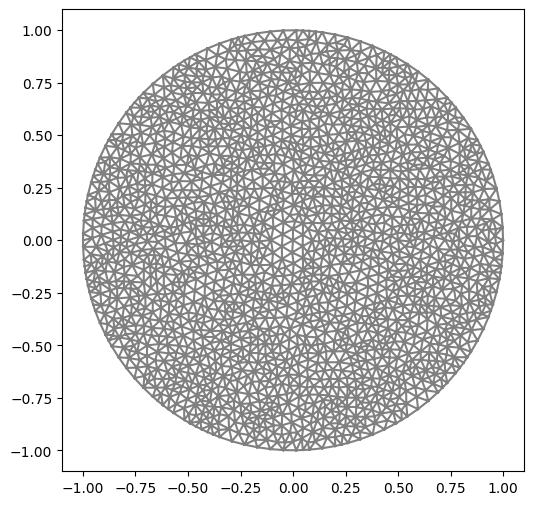

In [4]:
#@title Definizione della geometria $\Omega$
# costruiamo la nostra geometria e generiamo la mesh con circa
# 32 elementi per lato (triangoli di default)
Omega = Circle(centro,raggio)

mesh = generate_mesh(Omega, 32)
plot(mesh)

In [5]:
#@title Definiamo $ \langle \varphi_i \rangle $  e  $ V_h $ con $ \varphi_i \in \mathbb{P}^1 $
# definiamo le nostre funzioni di base (lagrangiane) sul nostro elemento finito
V_element = FiniteElement('Lagrange', triangle, 1)
V = FunctionSpace(mesh, V_element) # = V_h
del_prints()

Done!


In [6]:
#@title $v$ ed $u$
# a questo punto:
# definiamo le funzioni trial che useremo nel posto dell'incognita u del sistema lineare
# definiamo le funzioni test con il quale testiamo il problema
u = TrialFunction(V) # corrispondono alle colonne del sistema
v = TestFunction(V)  # corrispondono alle righe del sistema

In [7]:
#@title Parametro $\mu$
mu1 = Constant(1.0)
mu2 = Constant(1.0)
m1, m2 = 0.5, -1

mu1.assign(m1)
mu2.assign(m2)
print(f'utilizzeremo i parametri {m1} e {m2} per i nostri primi test')

utilizzeremo i parametri 0.5 e -1 per i nostri primi test


In [8]:
#@title Diffusività
a_expr = Expression(a_str, degree=1, mu1=mu1, mu2=mu2)
print('utilizziamo a(x; mu) =', a_str)

utilizziamo a(x; mu) = 5 + mu1*x[0] + mu2*x[1]


In [9]:
#@title Boundary conditions
g_expr = Expression(bc_str, degree=2, mu1=mu1, mu2=mu2)
BC = DirichletBC(V, g_expr, "on_boundary")
print("usiamo condizioni al bordo g(x; mu) = " + bc_str)

usiamo condizioni al bordo g(x; mu) = mu1 * (x[0] + pow(x[0],2) + pow(x[1],2)) + mu2 * (x[1] + x[0]*x[1])


### Considerazioni teoriche

Il problema è **coercivo** (Poisson su dominio limitato con $a(x;\mu) \geq 3$) \
- Ricordiamo che:\
data una forma bilineare $a(u,v;\mu)$ diciamo che questa è coerciva se $a(u,v;\mu) \geq \alpha(\mu) \ ||v||^2_{H_0^1}$ con $\alpha(\mu)$ coefficiente di coercività.
- in altre parole:
  - $a(\cdot,\cdot;\mu)$ controlla la norma $ ||v||$
  - Nessuna "direzione" di $v$ può sfuggire al controllo (nessuna degenerazione)

\
Nel nostro caso abbiamo:

1. $a(x;\mu) \geq \underline{a} > 0$ per ogni $x \in \Omega$, $\mu \in \mathcal{P}$  
   - $ a(x; \mu) = 5 + \mu_1 x_1 + \mu_2 x_2 \geq 1 \Rightarrow \alpha(\mu) \geq 1$

2. Il dominio $\Omega$ è limitato e regolare, quindi:
   - Poincaré: $\|v\|_{L^2} \leq C \|\nabla v\|$ \
   $\Rightarrow$ la norma $H^1_0$ è equivalente a $\|\nabla v\|$

3. La forma bilineare è:
   $$
   a(u, v; \mu) = \int_{\Omega} a(x; \mu)\, \nabla u(x) \cdot \nabla v(x) \, dx
   $$
   Esplicitamente:
   $$
   a(u, v; \mu) =
\int_{\Omega} \left(5 + \mu_1 x_1 + \mu_2 x_2\right) \nabla u \cdot \nabla v \, dx =
   $$

   $$
    = \underbrace{\int_{\Omega} 5\, \nabla u \cdot \nabla v \, dx}_{=: a_0(u, v)}
   + \mu_1 \underbrace{\int_{\Omega} x_1\, \nabla u \cdot \nabla v \, dx}_{=: a_1(u, v)}
   + \mu_2 \underbrace{\int_{\Omega} x_2\, \nabla u \cdot \nabla v \, dx}_{=: a_2(u, v)}
   $$

   che è **simmetrica**, **positiva definita**, e **uniformemente ellittica**


\
Otteniamo quindi:
- Esistenza e unicità della soluzione per il teorema di Lax-Milgram
- Stabilità numerica per Finite Element Method (FEM)
- Errori stimabili a posteriori
- RBM certificabile cioè è possibile stimare l’errore tra soluzione ridotta e completa

## FEM


Riscriviamo l'incognita della PDE come
$$
u = w + u_{\text{lift}},
$$
dove
$$
w|_{\partial \Omega} = 0, \quad u_{\text{lift}}|_{\partial \Omega} = g(x; \mu),
$$
cioè $u_{\text{lift}}$ estende la condizione al bordo all'interno del dominio.

Con coefficiente diffusivo $a(x; \mu)$, la PDE per $w$ diventa:
$$
- \nabla \cdot (a(x; \mu) \nabla w) = f - \nabla \cdot (a(x; \mu) \nabla u_{\text{lift}}) \quad \text{in } \Omega,
$$
con
$$
w|_{\partial \Omega} = 0.
$$

In [10]:
#@title Calcolo LHS e RHS per $u_{lift}$ (problema con lifting)

# definiamo la funzione lifting u_lift, tc u_lift = g su ∂Ω
u_lift = TrialFunction(V) # soddisfa la BC g

# risolviamo -Δ(u_lift) = 0 with u_lift = g on ∂Ω
lhs_lift = a_expr * inner(grad(u_lift), grad(v)) * dx
rhs_lift = Constant(0.0) * v * dx

LHS_lift = assemble(lhs_lift)
RSH_lift = assemble(rhs_lift)

BC.apply(LHS_lift)
BC.apply(RSH_lift)

del_prints()
print(type(LHS_lift), type(u_lift), type(RSH_lift))

Done!
<class 'dolfin.cpp.la.Matrix'> <class 'dolfin.function.argument.Argument'> <class 'dolfin.cpp.la.Vector'>


In [11]:
#@title Risoluzione per $u_{lift}$
ul_sol = Function(V)
solve(LHS_lift, ul_sol.vector(), RSH_lift)

1

In [12]:
#@title Calcolo LHS e RHS per $w:=\tilde{u}$ (problema omogeneo)

#Right-hand side del problema omogeneo f + Δ(u_lift) = f - div * ( grad(u_lift) )
f = Expression(f_str, degree=fdeg)
rhs_expr = f -div(grad(ul_sol))

# Risolvo per w in: -Δw = f + Δ(u_lift), w = 0 su ∂Ω
w = TrialFunction(V)
lhs_w = a_expr * inner(grad(w), grad(v)) * dx
rhs_w = rhs_expr * v * dx

LHS_w = assemble(lhs_w)
RHS_w = assemble(rhs_w)

zero_BC = DirichletBC(V, 0.0, "on_boundary")
zero_BC.apply(LHS_w)
zero_BC.apply(RHS_w)

del_prints()

Done!


In [13]:
#@title Risoluzione per $w$
w_sol = Function(V)
solve(LHS_w, w_sol.vector(), RHS_w)

1

In [14]:
#@title unione dei due risultati
# calcolo soluzione finale: u = w + u_lift
u_sol = Function(V)
u_sol.vector()[:] = w_sol.vector() + ul_sol.vector()

### Plot delle soluzioni $ u_{lift}, \, w, \, u $

In [15]:
#@title plotting function
def plottiaml(sol_list, titles=None):
    n = len(sol_list)
    if n == 0:
        print("La lista delle soluzioni è vuota.")
        return

    n_cols = min(n, 3)           # massimo 3 colonne
    n_rows = int(np.ceil(n / 3)) # tante righe quante servono

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    if n_rows == 1:
        axes = np.atleast_1d(axes)
    else:
        axes = axes.flatten()

    for i in range(n):
        plt.sca(axes[i])
        p = plot(sol_list[i])
        if titles is not None and i < len(titles):
            axes[i].set_title(titles[i])
        plt.colorbar(p)

    # Disattiva subplot vuoti
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    del_prints()
    plt.show()

Done!


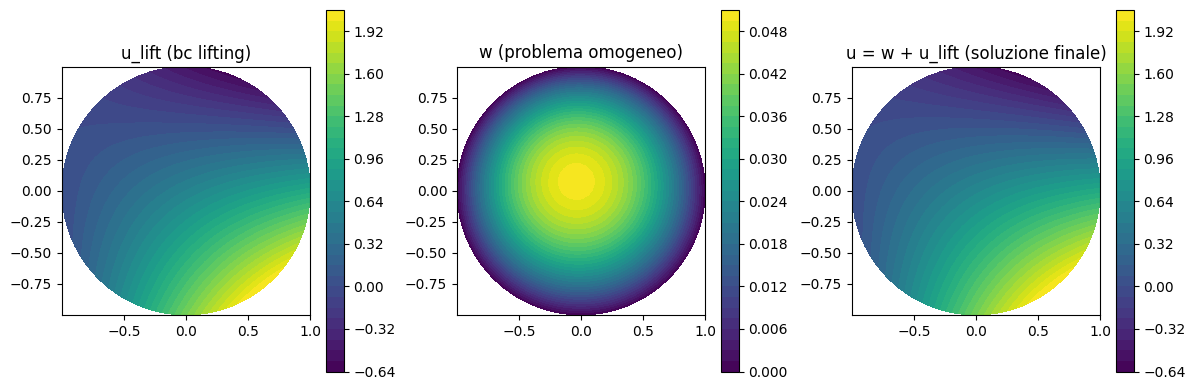

mu_1 = 0.5  ;  mu_2 = -1.0


In [16]:
plottiaml([ ul_sol              ,  w_sol                 ,  u_sol                             ],
          ["u_lift (bc lifting)", "w (problema omogeneo)", "u = w + u_lift (soluzione finale)"])
print('mu_1 =',float(mu1), ' ; ','mu_2 =', float(mu2))

In [17]:
N_dofs = len(u_sol.vector())
N_dofs

2022

### Truth solver

In [18]:
#@title Truth solver (compressione di tutto in una funzione)
def solve_for(V, mu1_val,mu2_val):

    u = TrialFunction(V)
    v = TestFunction(V)

    mu1 = Constant(1.0)
    mu2 = Constant(1.0)
    mu1.assign(mu1_val)
    mu2.assign(mu2_val)
    g_expr = Expression(bc_str, degree=2, mu1=mu1, mu2=mu2)
    a_expr = Expression(a_str , degree=1, mu1=mu1, mu2=mu2)
    BC = DirichletBC(V, g_expr, "on_boundary")

    u_lift = TrialFunction(V)
    lhs_lift = a_expr * inner(grad(u_lift), grad(v)) * dx
    rhs_lift = Constant(0.0) * v * dx

    LHS_lift = assemble(lhs_lift)
    RSH_lift = assemble(rhs_lift)
    BC.apply(LHS_lift)
    BC.apply(RSH_lift)
    ul_sol = Function(V)
    solve(LHS_lift, ul_sol.vector(), RSH_lift)

    f = Expression(f_str, degree=fdeg)
    rhs_expr = f + -div(grad(ul_sol))
    w = TrialFunction(V)
    lhs_w = a_expr * inner(grad(w), grad(v)) * dx
    rhs_w = rhs_expr * v * dx

    LHS_w = assemble(lhs_w)
    RHS_w = assemble(rhs_w)

    zero_BC = DirichletBC(V, 0.0, "on_boundary")
    zero_BC.apply(LHS_w)
    zero_BC.apply(RHS_w)

    w_sol = Function(V)
    solve(LHS_w, w_sol.vector(), RHS_w)

    u_sol = Function(V)
    u_sol.vector()[:] = w_sol.vector() + ul_sol.vector()

    del_prints()
    return ul_sol.copy(deepcopy=True), w_sol.copy(deepcopy=True), u_sol.copy(deepcopy=True)

In [19]:
ul_sol, w_sol, u_sol = solve_for(V, mu1_val = m1, mu2_val = m2)
#plottiaml([ul_sol, w_sol, u_sol]) # per controllare che dia lo stesso risultato in caso di diffidenza

Done!


##RBM

### Offline stage

Costruiamo il **manifold delle soluzioni**:

$$
\mathcal{M}_\delta = \{ u_\delta(\mu) \mid \mu \in \mathcal{P} \}
$$

dove ogni $u_\delta(\mu)$ è ottenuta risolvendo il problema completo per un parametro $\mu = (\mu_1, \mu_2)$ nel sottospazio scelto dallo spazio dei parametri. Queste soluzioni si chiamano **snapshots**.


In [20]:
#@title $\mu$ grid
# costruiamo la griglia di parametri con i quali risolveremo i nostri sistemi
mus = np.array([[m_1, m_2] for m_1 in np.linspace(a, b, 5) for m_2 in np.linspace(a, b, 5)])
M = len(mus)
M

25

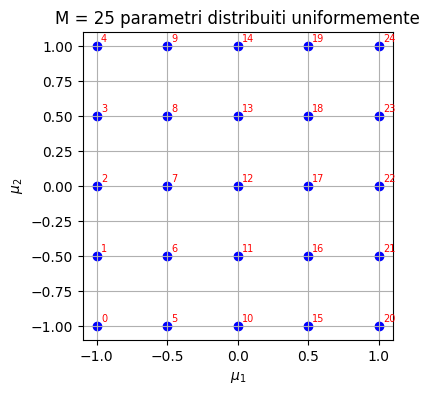

In [21]:
#@title visualizzazione
plt.figure(figsize=(4, 4))
plt.scatter(mus[:, 0], mus[:, 1], c='blue', label='Parametri selezionati')
for k, (x, y) in enumerate(mus):
    plt.text(x + 0.03, y + 0.03, str(k), fontsize=7, color='red')
plt.grid(True)
plt.title(f"M = {M} parametri distribuiti uniformemente")
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.show()

In [22]:
#@title Costruiamo la matrice $U$ di snapshots con dimensionalità $ \ N_{dofs} \times M$ con $N_{dofs} := N_{\delta}$
U = np.zeros(shape=(N_dofs,M))
j = 0
np.random.seed(42)
np.random.shuffle(mus)
for m_1, m_2 in mus:
    _, _, u_sol = solve_for(V, m_1, m_2)
    U[:,j]=u_sol.vector().get_local()
    j+=1

Done!


In [23]:
#@title visualizziamo le soluzioni trovate (se vogliamo)
we_want = False
#we_want = True

# siamo passati da  u_sol -----------------------------> u_sol.vector() -------------> u_sol.vector().get_local())
#        quindi da 'dolfin.function.function.Function'->'dolfin.cpp.la.PETScVector'->'numpy.ndarray'
# torniamo da class 'numpy.ndarray a class 'dolfin.function.function.Function'>

if we_want:
    i1 = np.random.randint(0, M)
    u1 = Function(V)
    u1.vector().set_local(U[:,i1]); u1.vector().apply("insert")

    plottiaml([u1])

else: print('non vogliamo')

non vogliamo


Ora utilizziamo la **Proper Orthogonal Decomposition (POD)** per ottenere una base ridotta ottimale nel senso $L^2$.

Si considera la matrice dei dati:

$$
U = [u_\delta(\mu_1), u_\delta(\mu_2), \ldots, u_\delta(\mu_M)] \in \mathbb{R}^{N_\delta \times M}
$$

e si effettua la decomposizione SVD:

$$
U = W \Sigma V^T
$$

Gli autovettori singolari sinistri $\xi_i$ (colonne di $U_{svd} := W$) sono le funzioni base e proendendo i primi $K$ formiamo la base ridotta:

$$
V_{\text{rb}} = \text{span}\{\xi_1, \ldots, \xi_K\}
$$

che minimizza l'errore medio tra gli snapshot e le loro proiezioni.


In [24]:
#@title Eseguiamo la SVD e riduciamo
U_mean = np.mean(U, axis=1, keepdims=True)
U_centered = U - U_mean
#U_svd, S, VT = svd(U_centered, full_matrices=False)
U_svd, S, VT = svd(U, full_matrices=False)

print(U.shape)

# Numero di funzioni base ridotte da conservare
K = 9
RB = U_svd[:, :K]  # colonne = basi ridotte, N_dofs x K

print(f"Costruito spazio ridotto con K = {K} basi su {U.shape[0]} DOF originali.")
print(f'la dimensione della nostra base ridotta è {RB.shape}')

(2022, 25)
Costruito spazio ridotto con K = 9 basi su 2022 DOF originali.
la dimensione della nostra base ridotta è (2022, 9)


Ora plottando la matrice S possiamo visualizzare quanto valgono i valori singolari, questo ci da un idea di quanto possiamo ridurre le basi

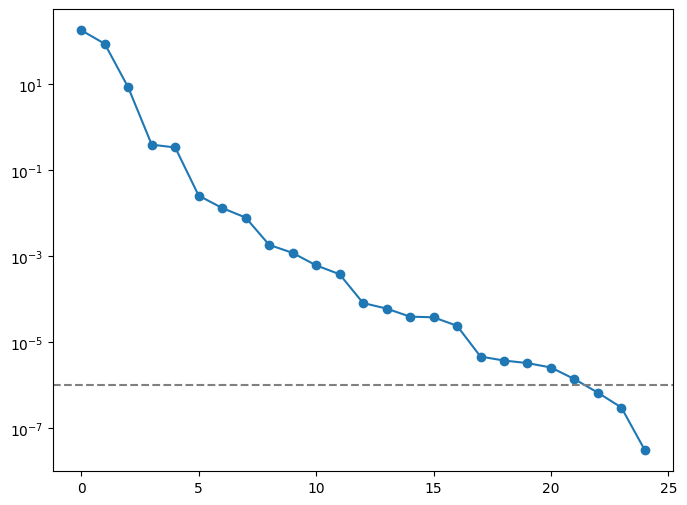

In [25]:
plt.semilogy(S, 'o-')
plt.axhline(1e-6, color='gray', linestyle='--')

###Online stage

Dato il sottospazio ridotto $V_{\text{rb}} = \text{span}\{\xi_1, \dots, \xi_K\}$, si cerca $u_{\text{rb}}(\mu) \in V_{\text{rb}}$ tale che soddisfi la **proiezione di Galerkin**, cioè tale che:

$$
a(u_{\text{rb}}(\mu), v; \mu) = f(v; \mu) \quad \forall v \in V_{\text{rb}}
$$

In pratica, il problema viene proiettato sulla base ridotta, riducendo drasticamente il costo computazionale. come facciamo?

Data una nuova coppia di parametri $\mu = (\mu_1, \mu_2)$, vogliamo:

1. Costruire il lifting per soddisfare le condizioni al bordo non omogenee.
2. Proiettare il problema variazionale nello spazio ridotto.
3. Risolviamo un sistema lineare piccolo di dimensione $K \times K$.
4. Ricostruiamo la soluzione approssimata:

$$
u_{rb}(x; \mu) \approx u_{lift}(x; \mu) + \sum_{i=1}^K c_i(\mu) \xi_i(x)
$$


Ora servono:

- La matrice ridotta:
  $ A_{\text{red}} = \Phi^T A \Phi $
- Il termine noto ridotto:
  $ b_{\text{red}} = \Phi^T (b - A u_L) $

In [26]:
#@title funzione per il calcolo del lifting
def compute_lift(V, mu1_val, mu2_val):

    u_lift = TrialFunction(V)
    v      = TestFunction(V)

    mu1 = Constant(mu1_val)
    mu2 = Constant(mu2_val)
    a_expr = Expression(a_str , degree=1, mu1=mu1, mu2=mu2)
    g_expr = Expression(bc_str, degree=2, mu1=mu1, mu2=mu2)
    BC = DirichletBC(V, g_expr, "on_boundary")

    a_form = a_expr * inner(grad(u_lift), grad(v)) * dx
    L_form = Constant(0.0) * v * dx

    A = assemble(a_form)
    b = assemble(L_form)
    BC.apply(A, b)

    u_lift_sol = Function(V)
    solve(A, u_lift_sol.vector(), b)

    del_prints()
    return u_lift_sol

In [27]:
#@title funzione per calcolo di $u_{rb}$
def solve_online(V, RB, mu1_val, mu2_val, U_mean, pre_lift=False):

    mu1 = Constant(1.0)
    mu2 = Constant(1.0)
    mu1.assign(mu1_val)
    mu2.assign(mu2_val)

    # Calcolo del lifting
    if pre_lift: u_lift = compute_lift_affine(m1, m2, u1_parts, u2_parts, V)
    else: u_lift = compute_lift(V, mu1_val, mu2_val)

    # Assemblaggio residuo modificato
    u = TrialFunction(V)
    v = TestFunction(V)

    a_expr = Expression(a_str , degree=1, mu1=mu1, mu2=mu2)
    f = Expression(f_str, degree=fdeg)
    rhs_expr = f - div(grad(u_lift))

    a_form = a_expr * inner(grad(u), grad(v)) * dx
    f_form = rhs_expr * v * dx

    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    A, F = assemble_system(a_form, f_form, bc)

    # conversione a matrice scipy
    A_csr = as_backend_type(A).mat().getValuesCSR()
    A_mat = scipy.sparse.csr_matrix((A_csr[2], A_csr[1], A_csr[0]))
    f_vec = F.get_local()

    # Proiezione nel sottospazio ridotto
    A_rb = RB.T @ A_mat @ RB
    f_rb = RB.T @ f_vec
    u_rb_coeffs = np.linalg.solve(A_rb, f_rb)

    # Ricostruzione soluzione finale
    u_rb_vec = RB @ u_rb_coeffs
    u_high_vec = u_rb_vec #+ U_mean.flatten()

    # Aggiunta anche del lifting
    u_total = Function(V)
    u_total.vector()[:] = u_high_vec + u_lift.vector()

    del_prints()
    return u_total

Confrontiamo ora la soluzione completa vista prima

Done!


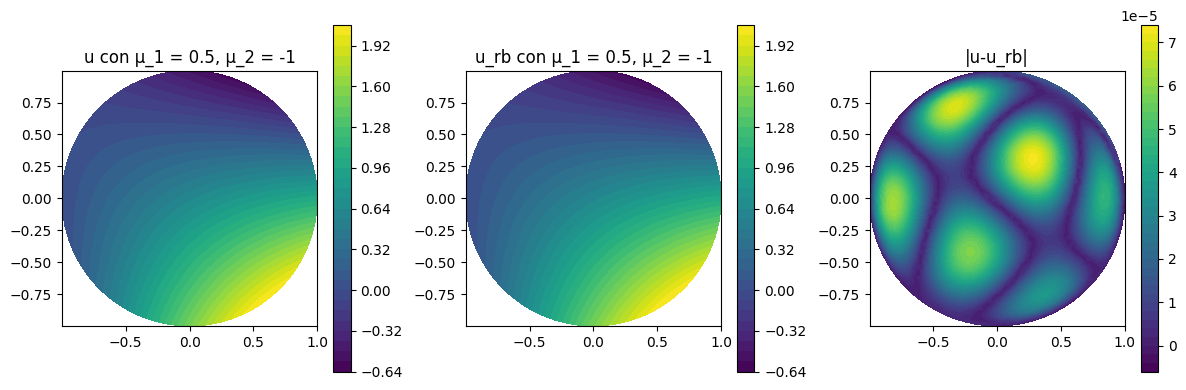

l'errore relativo è 3.769391729884312e-05 
la differenza massima è 7.281690933302887e-05 
la differenza minima è 1.6402036275399781e-09 


In [28]:
#@title plot comparazione u_lift
_, _, u_full = solve_for(V, m1, m2)
u_rb = solve_online(V, RB,  m1, m2, U_mean)
rel_err = np.linalg.norm(u_rb.vector().get_local() - u_full.vector().get_local()) / np.linalg.norm(u_full.vector().get_local())

r = np.abs(u_full - u_rb)
difmax = np.max(np.abs(u_rb.vector().get_local() - u_full.vector().get_local()))
difmin = np.min(np.abs(u_rb.vector().get_local() - u_full.vector().get_local()))

plottiaml([u_full, u_rb, r],
          [f'u con μ_1 = {m1}, μ_2 = {m2}', f'u_rb con μ_1 = {m1}, μ_2 = {m2}', f'|u-u_rb|'])
print(f"l'errore relativo è {rel_err} ")
print(f"la differenza massima è {difmax} ")
print(f"la differenza minima è {difmin} ")


Molto bene! ora proviamo a farlo per più parametri cosi vediamo se è solo un caso

In [29]:
#@title funzione calcolo errore relativo per $ \{ \mu_{test}^{(1)},..., \mu_{test}^{(\text{test_size})} \} $  scelti uniformemente
def test_rbm_accuracy(V, RB, U_mean, test_size=5):

    test_mus = np.random.uniform(a, b, (test_size, 2))
    errors = np.zeros((test_size,))

    for i,m in enumerate(test_mus):
        m_1,m_2 = m
        _, _, u_full = solve_for(V, m_1, m_2)
        u_rb = solve_online(V, RB, m_1, m_2, U_mean)
        errors[i] = np.linalg.norm(u_rb.vector().get_local() - u_full.vector().get_local()) / np.linalg.norm(u_full.vector().get_local())

    # statistiche
    err_mean = np.mean(errors)
    err_max = np.max(errors)
    err_min = np.min(errors)

    print("\nStatistiche errori:")
    print(f"Errore medio   : {err_mean}")
    print(f"Errore massimo : {err_max}")
    print(f"Errore minimo  : {err_min}")

    return test_mus, errors

In [30]:
np.random.seed(42)
test_mus, errors = test_rbm_accuracy(V, RB, U_mean, test_size=30)

Done!

Statistiche errori:
Errore medio   : 1.613474946945773e-05
Errore massimo : 3.9251397505663674e-05
Errore minimo  : 2.167526488918631e-06


Perfetto!